In [32]:
import pandas as pd

#url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv'
#df = pd.read_csv(url,index_col=0)
#df.to_csv('raw.csv', sep=',')


In [33]:
from datetime import datetime
import numpy as np



def read_data(filename):
   df = pd.read_csv('Data_Mexico_COVID19/Tables/'+filename, index_col=0)
   # for col = "activ9", add all rows into 1 values. Repeat for other cols.
   df.drop("CVEGEO", axis=1, inplace=True) # Drop 0th column
   df.drop("Pop2010", axis=1, inplace=True) # Drop 0th column
   df.drop("Pop2020", axis=1, inplace=True) # Drop 0th column
   active = df.sum(numeric_only=True, axis=0)
   active = active.reset_index()
   active = np.asarray(active[0])
   #print(active) # len = 122
   return active, df # df is just without summing all cities.
   
   # Returns a 1d np array which will be appended as a column

def process_COVID_dataset():
   new, new_cities = read_data('tab_new.csv') # Labels
   active, active_cities = read_data('tab_activ.csv')
   deaths, deaths_cities = read_data('tab_death.csv')
   accum, accum_cities = read_data('tab_cumul.csv')
   # Now, we have 4 parallel arrays of features across 122 weeks. 

   # ROWS: time 1->122
   # COLS: features summed over all municipalities. 
   # Note: for ST-GNN model, we will treat each municipality as a separate subgraph OR node?? 
   dataset = pd.DataFrame(np.asanyarray([new, active, deaths, accum]).T, columns=['new', 'active', 'deaths', 'accum'])
   # Note: 'new' is target in num new cases that week. For this setting at least.
   # summarize first 5 rows
   print(dataset.head(5))
   # TODO: save to file
   dataset.to_csv('country_weeks.csv')
   return dataset, new_cities, active_cities, deaths_cities, accum_cities
   
dataset, new_cities, active_cities, deaths_cities, accum_cities = process_COVID_dataset()

    new  active  deaths  accum
0     8      16       0      8
1    50     129       0     58
2   228     663       0    286
3   702    1753       4    988
4  1319    3586      39   2307


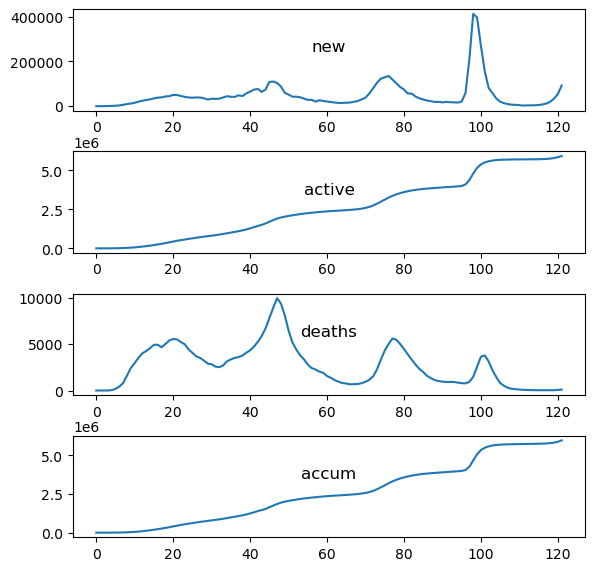

In [34]:
from matplotlib import pyplot
# load dataset
dataset = pd.read_csv('country_weeks.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3,]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5)
 i += 1
pyplot.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.2,
                    wspace=0.4,
                    hspace=0.4)
pyplot.show()

Text(0, 0.5, 'city id')

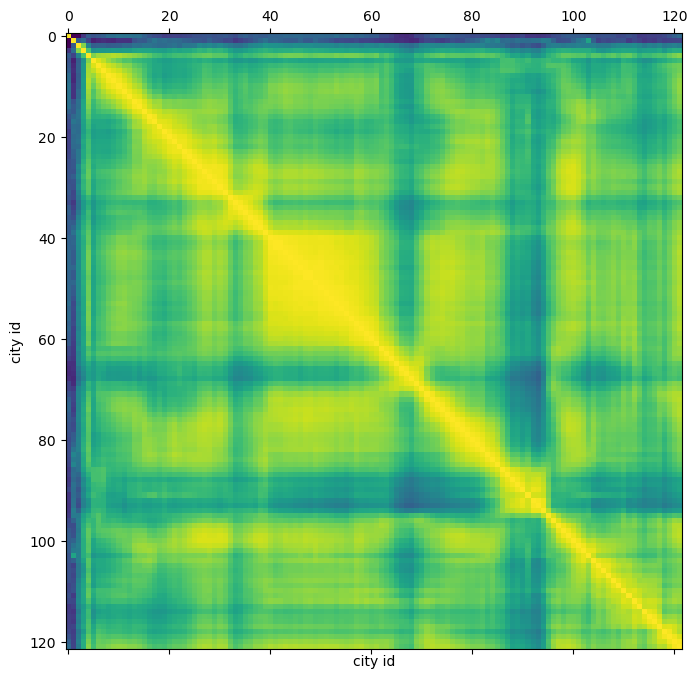

In [35]:
# Heatmap between all cities for: New, active, deaths, and accum cases. 
import matplotlib.pyplot as plt
# New cases
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(new_cities.T), 0)
plt.xlabel("city id")
plt.ylabel("city id")



Text(0, 0.5, 'city id')

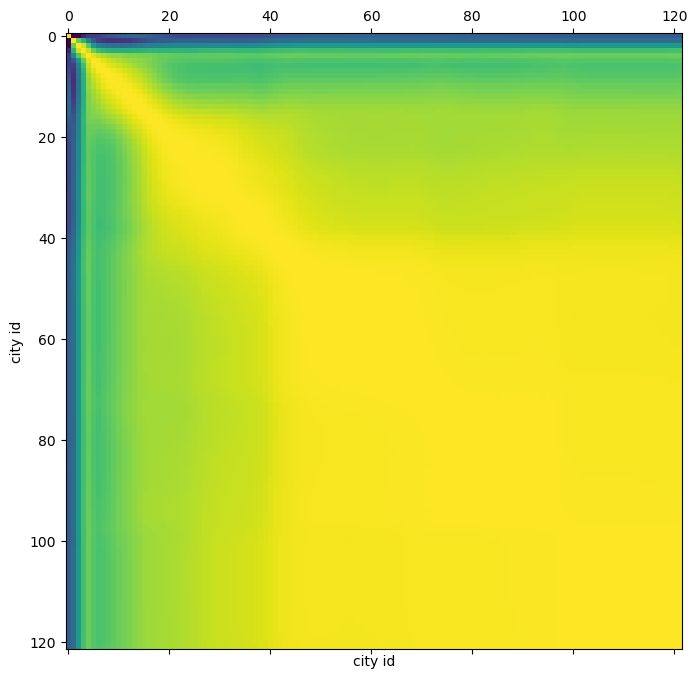

In [36]:
import matplotlib.pyplot as plt
# Active cases
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(active_cities.T), 0)
plt.xlabel("city id")
plt.ylabel("city id")

/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0, 0.5, 'city id')

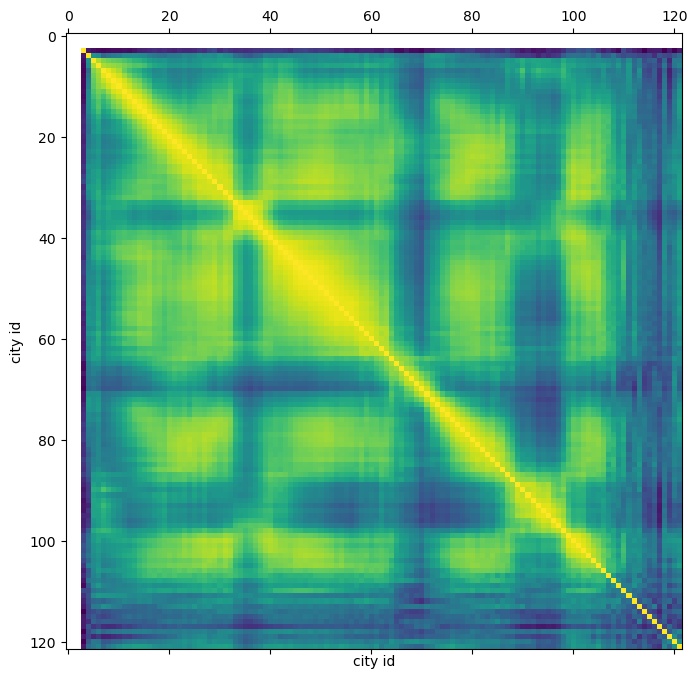

In [37]:
import matplotlib.pyplot as plt
# Deaths cases
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(deaths_cities.T), 0)
plt.xlabel("city id")
plt.ylabel("city id")

Text(0, 0.5, 'city id')

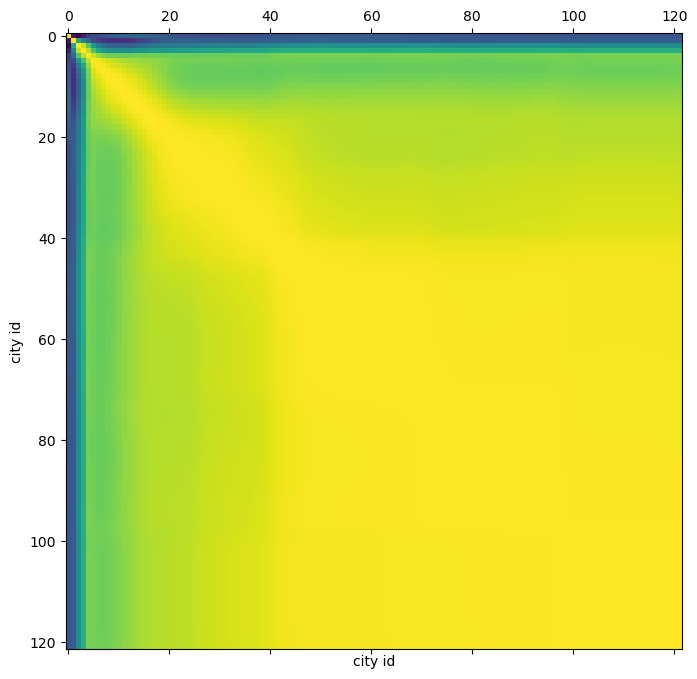

In [38]:
# Accumulated cases
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(accum_cities.T), 0)
plt.xlabel("city id")
plt.ylabel("city id")

# 1. Baseline LSTM model 
- *For this model, we do NOT consider dynamics between cities. We sum all city features across the entire country.*
- Task: We will frame the supervised learning problem as predicting the cases at the current week (t) given the case measurements (see below for features used) conditions at the prior time step.

- Time scale (weeks): t = 9, ..., 130 (i.e.1 -> 122)
- Population from 2020 in municipality: column: "Pop2020"

- 1. Active counts/municipality: [tab_activ.csv]
    - Active rate wrt 2020 population/municipality: [tab_activrate.csv]

- 2. New confirmed cases/municipality: [tab_new.csv]

- 3. Deaths for municipality: [tab_death.csv]
    - Death rate for municipality: [tab_deathrate.csv]
- Note: Accumulated cases for municipality: [tab_cumul.csv]


Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

In [39]:
# prepare data for lstm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = pd.read_csv('country_weeks.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[1, 2, 3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)   var1(t)   var2(t)   var3(t)   var4(t)
1   0.000000  0.000102  0.000019  0.000000  0.000008
2   0.000102  0.000534  0.000109  0.000000  0.000047
3   0.000534  0.001686  0.000294  0.000403  0.000164
4   0.001686  0.003184  0.000604  0.003929  0.000385
5   0.003184  0.005304  0.001125  0.017229  0.000752


In [40]:
import math
# split into train and test sets
values = reframed.values
n_train_hours = math.floor(122 * 0.7) # 122 weeks
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(85, 1, 4) (85,) (36, 1, 4) (36,)


Epoch 1/40
17/17 - 1s - loss: 0.2237 - val_loss: 0.7690 - 1s/epoch - 74ms/step
Epoch 2/40
17/17 - 0s - loss: 0.1791 - val_loss: 0.6876 - 34ms/epoch - 2ms/step
Epoch 3/40
17/17 - 0s - loss: 0.1512 - val_loss: 0.6128 - 34ms/epoch - 2ms/step
Epoch 4/40
17/17 - 0s - loss: 0.1414 - val_loss: 0.5700 - 33ms/epoch - 2ms/step
Epoch 5/40
17/17 - 0s - loss: 0.1402 - val_loss: 0.5460 - 34ms/epoch - 2ms/step
Epoch 6/40
17/17 - 0s - loss: 0.1351 - val_loss: 0.5260 - 32ms/epoch - 2ms/step
Epoch 7/40
17/17 - 0s - loss: 0.1279 - val_loss: 0.5002 - 31ms/epoch - 2ms/step
Epoch 8/40
17/17 - 0s - loss: 0.1218 - val_loss: 0.4723 - 31ms/epoch - 2ms/step
Epoch 9/40
17/17 - 0s - loss: 0.1161 - val_loss: 0.4458 - 31ms/epoch - 2ms/step
Epoch 10/40
17/17 - 0s - loss: 0.1088 - val_loss: 0.4155 - 30ms/epoch - 2ms/step
Epoch 11/40
17/17 - 0s - loss: 0.1011 - val_loss: 0.3808 - 31ms/epoch - 2ms/step
Epoch 12/40
17/17 - 0s - loss: 0.0938 - val_loss: 0.3475 - 30ms/epoch - 2ms/step
Epoch 13/40
17/17 - 0s - loss: 0.0847 

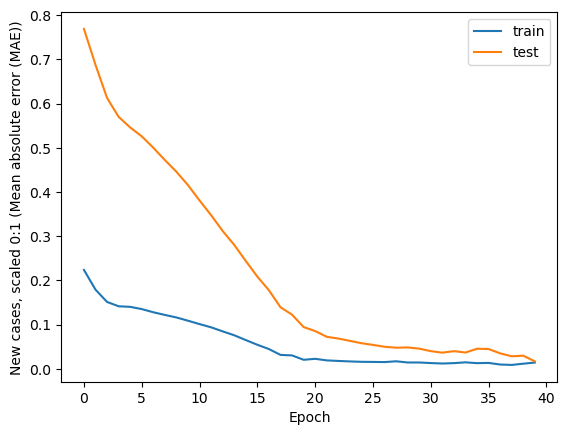

In [41]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network

history = model.fit(train_X, train_y, epochs=40, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel("Epoch")
pyplot.ylabel("New cases, scaled 0:1 (Mean absolute error (MAE))")
pyplot.legend()
pyplot.show()

In [42]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print(inv_y, "\n \n", inv_yhat)
print('Test MAE: %.3f' % mae)

# TODO: _____ instead of this RMSE, do MAE.

2/2 [==============================] - 0s 2ms/step
[263740.47 265288.7  266590.5  267932.38 269112.16 270416.1  271651.03
 272831.66 273947.   275389.03 279482.06 294028.03 322413.9  349719.4
 368296.22 379037.3  384673.53 388694.6  391070.56 392461.4  393386.44
 394042.75 394495.22 394921.22 395238.   395444.12 395699.4  395957.12
 396240.62 396596.16 397125.25 397959.66 399297.66 401643.3  405368.97
 411741.  ] 
 
 [261850.81 262605.16 263611.62 264381.2  265795.38 266656.16 268124.53
 269130.38 270135.9  272034.3  278763.44 300849.88 344984.66 393269.84
 411942.8  410899.44 404712.97 399198.12 397921.25 395754.   394551.56
 394014.94 393813.78 393692.9  393821.6  393694.4  393609.94 393826.7
 393983.44 394199.8  394791.88 395866.16 397745.44 401037.7  406798.66
 413630.84]
Test MAE: 6874.353


2. Time series forecasting of COVID-19 new cases using *Graph Neural Network LSTM*

Reference: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/ 

In [59]:
train_size, val_size = 0.6, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(new_cities, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")
print(f"test set: ", test_array)

train set size: (1479, 122)
validation set size: (493, 122)
test set size: (493, 122)
test set:            new9     new10    new11     new12     new13     new14     new15   
1973 -0.073721  1.587062 -0.10376  1.705953  6.511987  7.049326  5.180971  \
1974 -0.073721 -0.049803 -0.10376  0.599166  0.330356  0.123677  0.382247   
1975 -0.073721 -0.049803 -0.10376 -0.138691 -0.164175 -0.147917 -0.161004   
1976 -0.073721 -0.049803 -0.10376 -0.138691  0.083090 -0.012120 -0.070462   
1977 -0.073721 -0.049803 -0.10376 -0.138691 -0.164175 -0.012120 -0.070462   
...        ...       ...      ...       ...       ...       ...       ...   
2461 -0.073721 -0.049803 -0.10376 -0.138691 -0.164175 -0.147917 -0.161004   
2462 -0.073721 -0.049803 -0.10376 -0.138691  0.083090 -0.147917 -0.161004   
2463 -0.073721 -0.049803 -0.10376  0.230238  0.330356 -0.147917 -0.070462   
2464 -0.073721 -0.049803 -0.10376 -0.138691 -0.164175 -0.147917 -0.161004   
2465 -0.073721 -0.049803 -0.10376 -0.138691 -0.164175 -0

In [81]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

batch_size = 10
input_sequence_length = 5
forecast_horizon = 1
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

In [82]:
import re
# Build adj distance matrix (route_distances) to prepare for adj edge matrix.
cities_dist = pd.read_csv("pair_dist.csv", index_col=0)

route_distances = np.zeros([122,122])
# For each column name in cities_dist: [0]=city 1, [1] = city 2
for e in cities_dist.columns:
    col = cities_dist[e]
    names = col[0]
    names_list = [int(re.search(r'\((.*?),', names).group(1))]
    names_list.append(int(re.search(r',(.*?)\)', names).group(1)))
    dist = col[1]
    #print(dist)

    c1 = names_list[0] -1 # Since previously 1-indexed
    c2 = names_list[1] -1
    route_distances[c1, c2] = dist

print(route_distances[0, 3])


def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

1613.0


In [84]:
import typing 

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 1.0
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 122, number of edges: 14411


In [85]:
from keras import layers

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [86]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num

In [88]:
import keras 

in_feat = 2
batch_size = 10
epochs = 20
input_sequence_length = 5
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanAbsoluteError(), # Changed from MSE to MAE
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/__autograph_generated_fileode7ouq_.py", line 19, in tf__call
        gcn_out = ag__.converted_call(ag__.ld(self).graph_conv, (ag__.ld(inputs),), None, fscope)
    File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/__autograph_generated_filekmenftep.py", line 18, in tf__call
        nodes_representation = ag__.converted_call(ag__.ld(self).compute_nodes_representation, (ag__.ld(features),), None, fscope)
    File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/__autograph_generated_file1_wtbpc2.py", line 24, in tf__compute_nodes_representation
        retval_ = ag__.converted_call(ag__.ld(tf).matmul, (ag__.ld(features), ag__.ld(self).weight), None, fscope)

    ValueError: Exception encountered when calling layer "lstmgc_4" (type LSTMGC).
    
    in user code:
    
        File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/ipykernel_48827/4064654862.py", line 44, in call  *
            gcn_out = self.graph_conv(
        File "/opt/homebrew/Caskroom/miniforge/base/envs/base_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/__autograph_generated_filekmenftep.py", line 18, in tf__call
            nodes_representation = ag__.converted_call(ag__.ld(self).compute_nodes_representation, (ag__.ld(features),), None, fscope)
        File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/__autograph_generated_file1_wtbpc2.py", line 24, in tf__compute_nodes_representation
            retval_ = ag__.converted_call(ag__.ld(tf).matmul, (ag__.ld(features), ag__.ld(self).weight), None, fscope)
    
        ValueError: Exception encountered when calling layer "graph_conv_4" (type GraphConv).
        
        in user code:
        
            File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/ipykernel_48827/925699508.py", line 83, in call  *
                nodes_representation = self.compute_nodes_representation(features)
            File "/var/folders/r9/df73flk557sd9y_w2lz8fkrh0000gn/T/ipykernel_48827/925699508.py", line 57, in compute_nodes_representation  *
                return tf.matmul(features, self.weight)
        
            ValueError: Dimensions must be equal, but are 1 and 2 for '{{node model_4/lstmgc_4/graph_conv_4/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](model_4/lstmgc_4/transpose, model_4/lstmgc_4/graph_conv_4/MatMul/ReadVariableOp)' with input shapes: [122,?,?,1], [2,10].
        
        
        Call arguments received by layer "graph_conv_4" (type GraphConv):
          • features=tf.Tensor(shape=(122, None, None, 1), dtype=float32)
    
    
    Call arguments received by layer "lstmgc_4" (type LSTMGC):
      • inputs=tf.Tensor(shape=(None, None, 122, 1), dtype=float32)


16/16 [==============================] - 0s 19ms/step
naive MAE: 0.0007353642237575424, model MAE: -0.06976691846854857
0.001077258493689784
0.10873032012660884
-0.1711676401189807
0.36709766804561456
0.7115874652709555
-0.04198396615947784
-0.10657580313922926
-0.02045335383289403
-0.08504519081264546
-0.1711676401189807
-0.12810641546581308
0.15179154477977647
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
0.8407711392304583
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1496370277923969
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.04198396615947784
1.3790364473950538
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
-0.1711676401189807
0.17332215710636026
-0.1711676401189807
-0.1711676401189807
-0.1496370277923969
-0.1711676401189807
0.43168950502536596
-0.08504519081264546
-0.1711676401189807
-0.171167640118

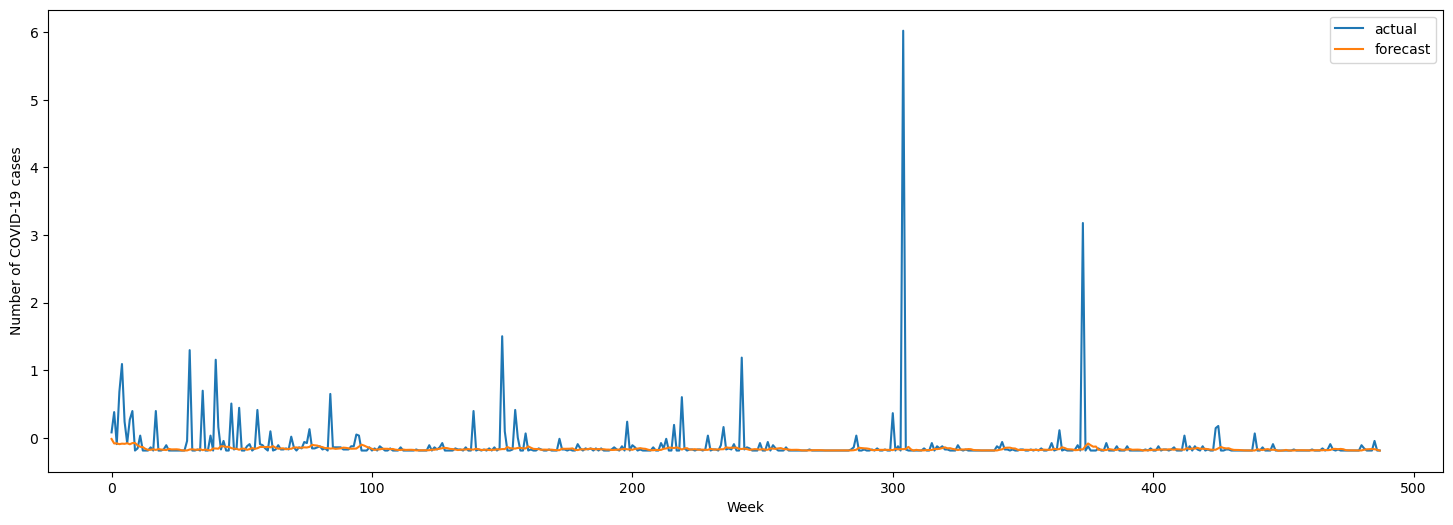

In [80]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)

'''
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])
'''
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 12])
plt.plot(y_pred[:, 0, 12])
plt.legend(["actual", "forecast"])
plt.ylabel("Number of COVID-19 cases")
plt.xlabel("Week")
# TODO: what is xlabel? Is it weeks???

naive_mse, model_mse = (
    (x_test[:, -1, :, 0] - y[:, 0, :]).mean(), # Not MSE, do MAE
    (y_pred[:, 0, :] - y[:, 0, :]).mean(), # Not MSE, do MAE
)




print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")


for e in y[:, 0, 10]:
    if e != -0.07372109667560463:
        print(e)